> Mathieu Fourment, University of Technology Sydney

# Table of contents
1. [The coalescent](#coalescent)
2. [Variational inference](#vb)
3. [Example: HCV](#hcv)
    1. [Variational inference](#hcv-vb)
    2. [Hamiltonian Monte Carlo](#hcv-hmc)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import math
sys.path.append(os.path.abspath('../lib'))
import torch
from torchtree.evolution.coalescent import ConstantCoalescent, PiecewiseConstantCoalescent
from torchtree.distributions.inverse_gamma import InverseGamma
from drawing import draw_tree
from tree import Node, random_tree_from_heights
from scipy.special import binom
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import trange
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline

/Users/mathieu/Projects/lib


In [69]:
_ = torch.manual_seed(0)

## The coalescent  <a name="coalescent"></a>

Let the coalescent times arising from genealogy $T$ of $N$ taxa be denoted $t_N = 0 < t_{N-1}< \dots< t_1$. The number of lineages associated with each interval $u_k = t_{k-1} - t_k$ is denoted $n_k$ and the vector concatenating the number of lineages is denoted $\boldsymbol{n}$.

### Constant population size
The joint distrubtion of the coalescent times given a constant population size $\theta$ is:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n}, \theta) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, \theta)\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{\theta} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta} \right]\\
\end{align}

The waiting time until the next coalescent event is exponentially distributed with rate ${n_{k} \choose 2}\frac{1}{\theta}$.


### Non parameteric population size
Suppose the function $Ne(t)$ describes the effective population size as we move into the past. The probability to observe $t_1, \dots, t_{N-1}$ given $Ne(t)$ can be written as:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n}, Ne(t)) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, Ne(t))\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{Ne(t_{k-1})} \exp \left[ -\int_{t_{k}}^{t_{k-1}} {n_{k} \choose 2} \frac{1}{Ne(t)} dt \right]\\
\end{align}

Since the integral is intractable we assume that changes in the trajectory of $Ne(t)$ coincinde with coalescent events, a piecewise constant trajectory of the population size function can be defined as $Ne(t) = \theta_k$ for $t_k < t \leq t_{k-1}$. Plugging $Ne(t) = \sum_{k=2}^N \theta_k 1_{(t_k,t_{k-1})}(t)$ in the previous equation gives the joint distribution:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n},\boldsymbol{\theta}) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, \theta_k)\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{\theta_k} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta_k} \right]
\end{align}

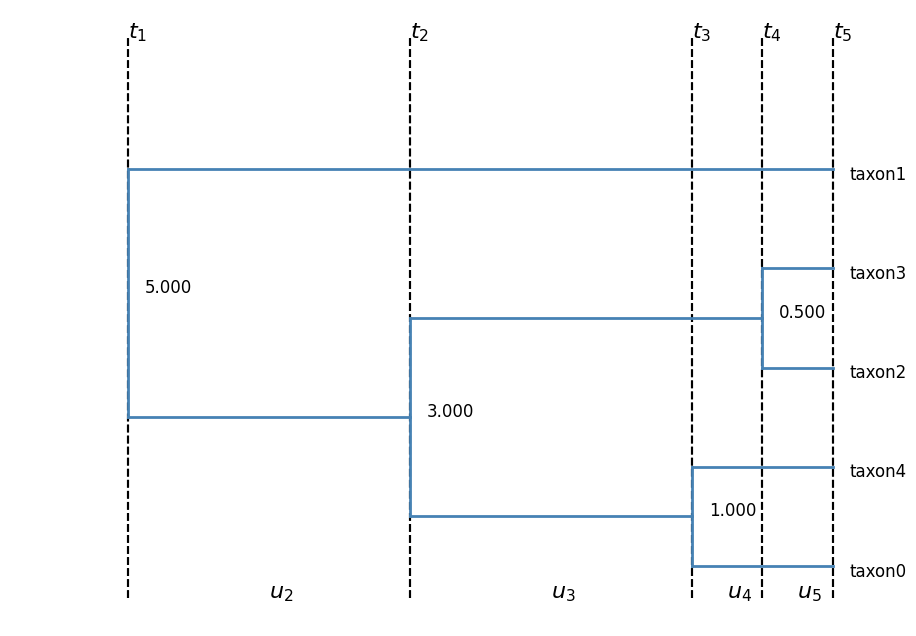

In [70]:
root = random_tree_from_heights([0.]*5, sorted([0.5,1,3,5]))
fig = plt.figure(figsize=(10,8), facecolor='w')
draw_tree(fig, root, rootLength=1,showHeightLabels=True)

## Simulated constant size coalescent

In [71]:
# simulate coalescent intervals for homochronous data
def simulate(theta, taxon_count):
    lineages = np.arange(taxon_count, 1, -1)
    cf = binom(lineages, 2)
    intervals = np.random.exponential(1.0/(cf/theta))
    return {'intervals': intervals,
            'heights': np.cumsum(intervals),
            'lineages': lineages}

# numpy function to calculate probability of intervals given population size
def constant_log_prob(intervals, lineages, theta):
    return np.sum(-np.log(theta) - binom(lineages, 2)/theta*intervals)

# simulate coalescent intervals for homochronous data

In [72]:
taxon_count = 50
true_theta = 4
sim = simulate(true_theta, taxon_count)
heights_list = list(sim['heights'])
lineages = sim['lineages']
intervals = sim['intervals']

times = heights_list

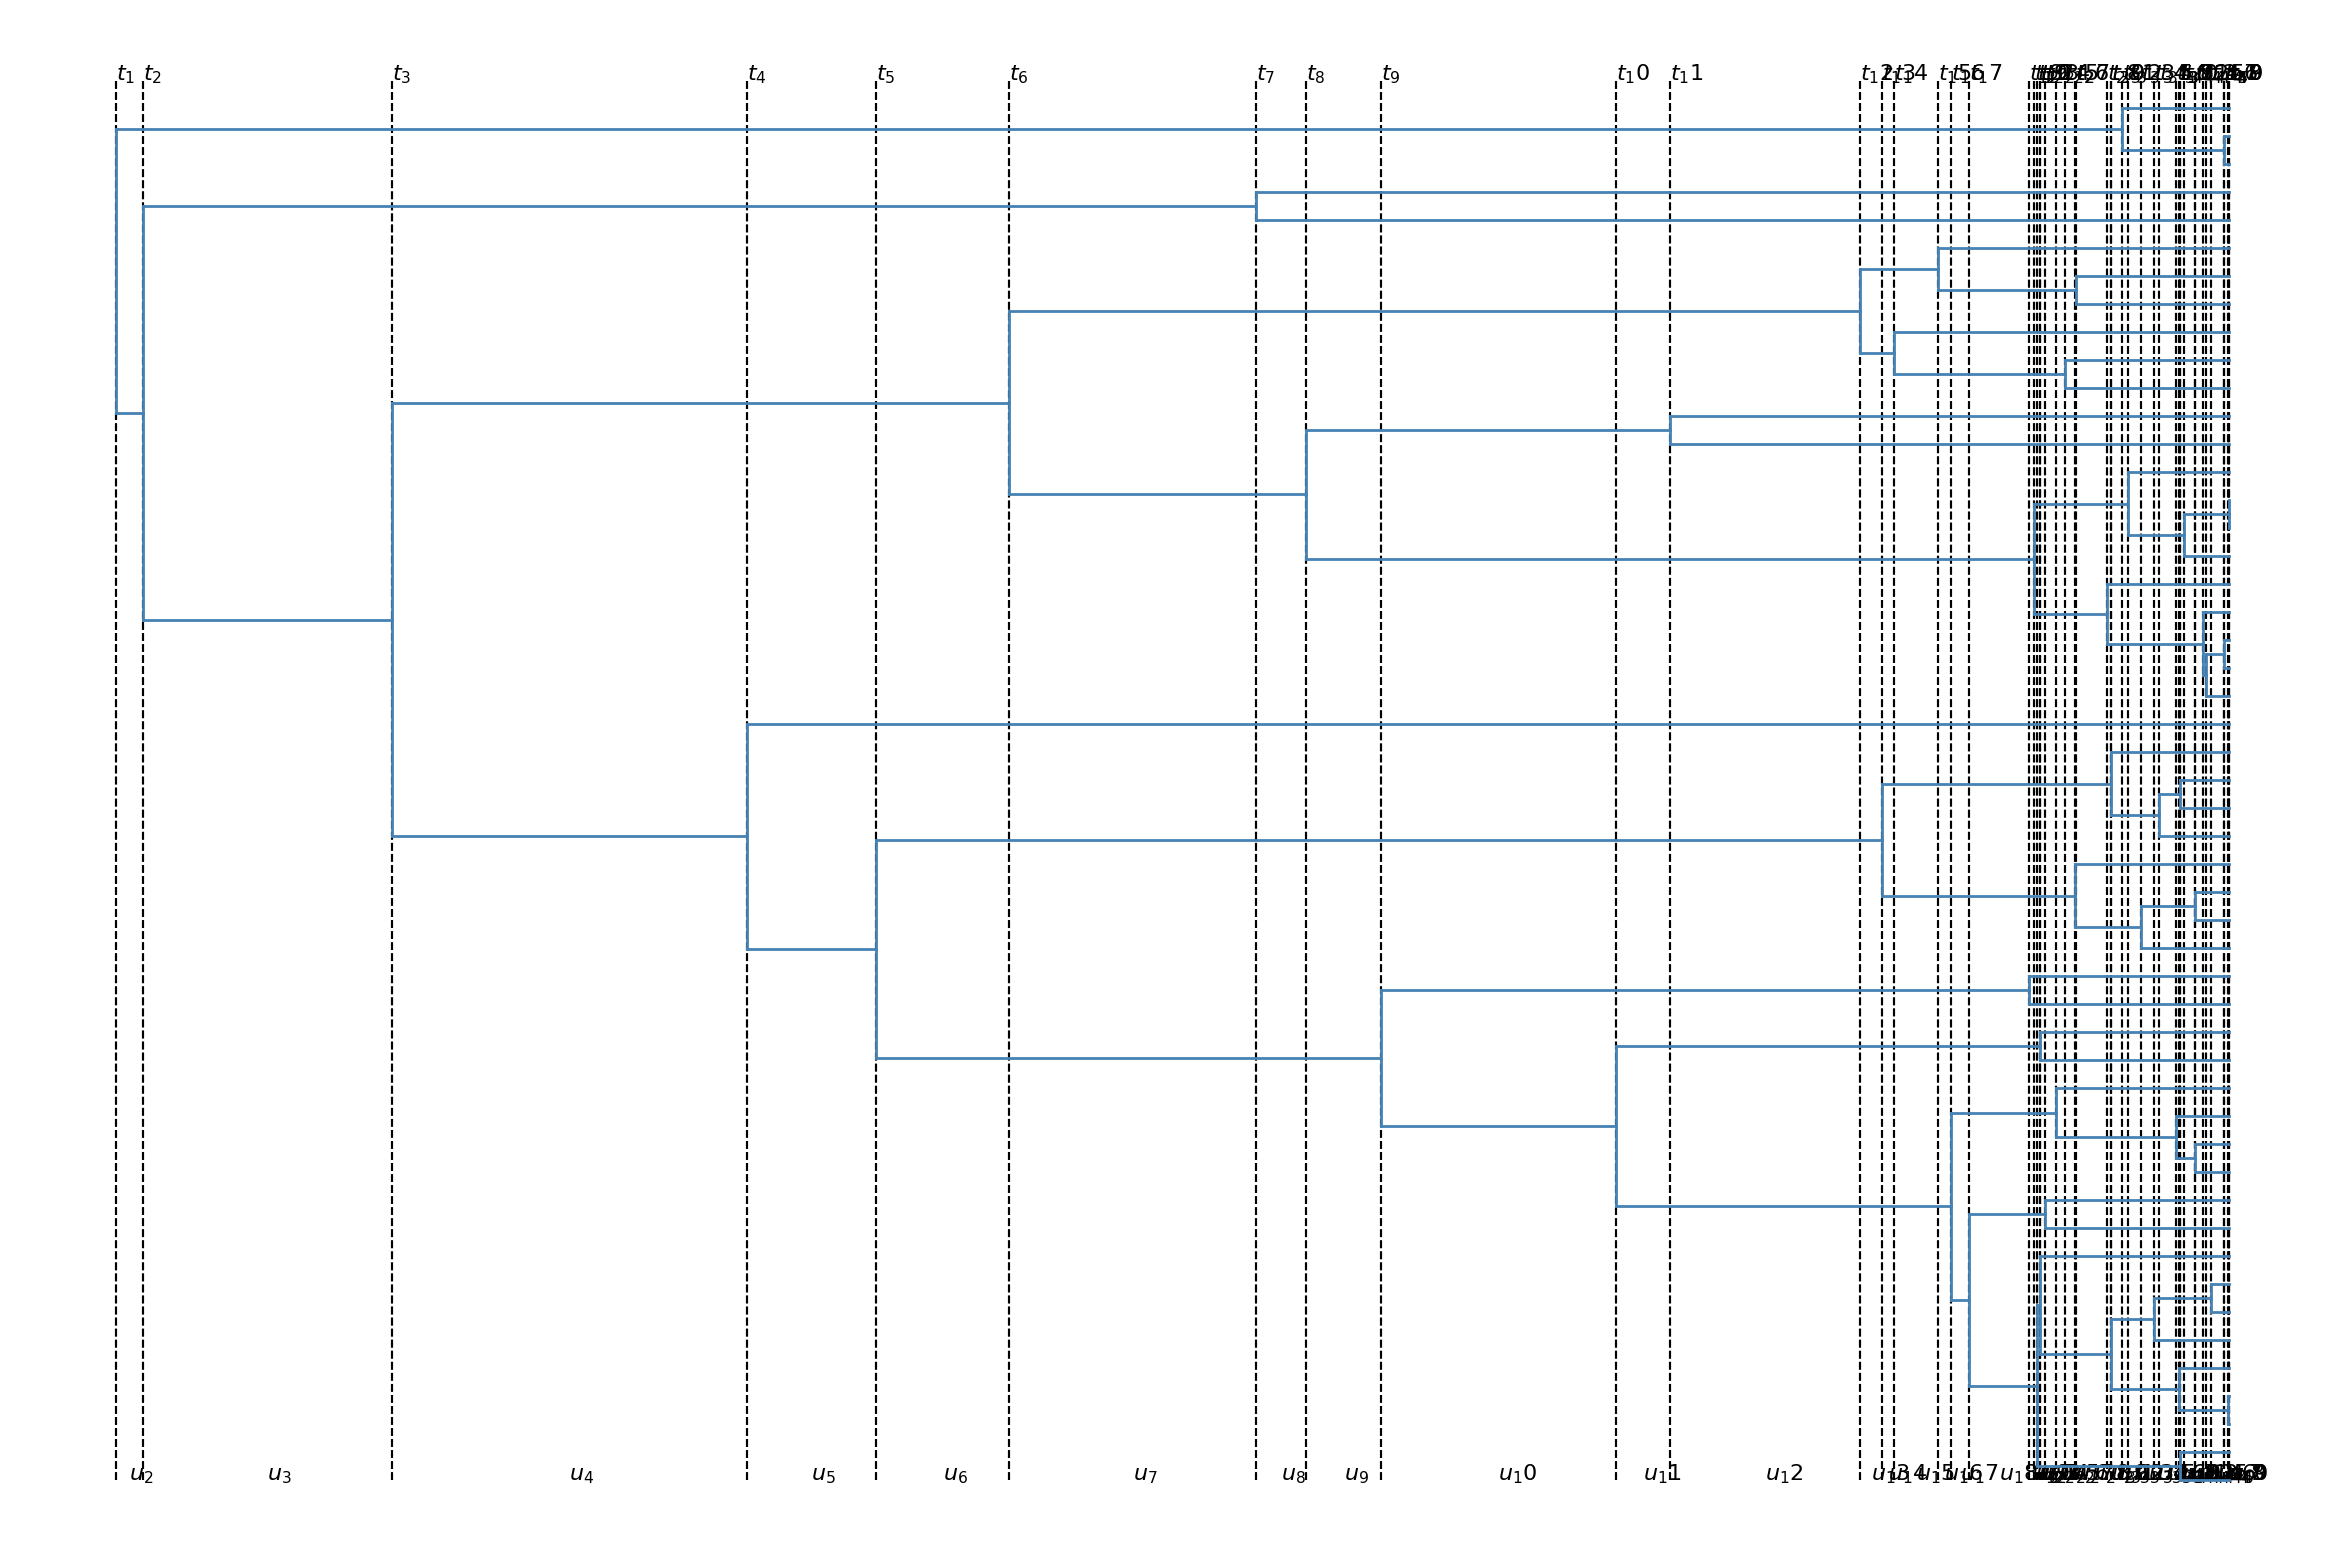

In [73]:
root = random_tree_from_heights([0.]*taxon_count, heights_list)
fig = plt.figure(figsize=(30,20), facecolor='w')
draw_tree(fig, root, rootLength=1,showTaxa=False, showHeights=False,showHeightLabels=True)

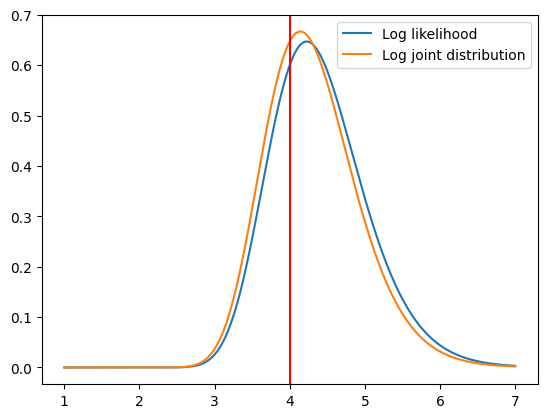

In [74]:
x = np.arange(1,7, 0.001)

# log likelihood along x
y1 = [constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), theta) for theta in x]
# log joint likelihood along x
y = [yy - np.log(theta) for theta, yy in zip(x, y1)]

y1 = np.exp(y1 - np.max(y1))
y1 = y1/np.sum(y1*0.001)

y = np.exp(y - np.max(y))
y = y/np.sum(y*0.001)

plt.plot(x, y1, label='Log likelihood')
plt.plot(x, y, label='Log joint distribution')
plt.axvline(true_theta, c='r')
plt.legend(loc="upper right")
plt.show()

The maximum likelihood estimator is:
$$\hat{\theta} = \frac{1}{N-1}\sum_{k=2}^N {k\choose 2} (t_{k-1} - t_k) $$

The maximum a posteriori estimator is:
$$\hat{\theta}_{MAP} = \frac{1}{N}\sum_{k=2}^N {k\choose 2} (t_{k-1} - t_k) $$

In [75]:
mle = np.sum(binom(lineages, 2) * intervals)/(taxon_count-1)
ml = constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), mle)
var = -1.0/((taxon_count-1)/mle**2 - 2.0*np.sum(binom(lineages, 2) * intervals)/(mle**3))
print('ML  theta = {:.2f} f(theta) = {:.2f} var(theta) = {:.2f}'.format(mle, ml, var))

mape = np.sum(binom(lineages, 2) * intervals)/(taxon_count)
mapp = constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), mape) - np.log(mape)
var = -1.0/((taxon_count+1)/mape**2 - 2.0*np.sum(binom(lineages, 2) * intervals)/(mape**3))
print('MAP theta = {:.2f} f(theta) = {:.2f} var(theta) = {:.2f}'.format(mape, mapp, var))

ML  theta = 4.23 f(theta) = -119.61 var(theta) = 0.36
MAP theta = 4.14 f(theta) = -121.05 var(theta) = 0.35


Using the Laplace method and the mean and variance from the normal approximation the parameters of the lognormal distribution are:

In [76]:
d2logP = (taxon_count+1)/mape**2 - 2.0*np.sum(binom(lineages, 2) * intervals)/(mape**3)
q_sigma_map = np.sqrt(-1.0/(d2logP*mape*mape))
q_mu_map = np.log(mape) + q_sigma_map*q_sigma_map
print('mu = {:.3f} sigma = {:.3f}'.format(q_mu_map, q_sigma_map))

mu = 1.441 sigma = 0.143


In [77]:
q_rate_map = mape * -d2logP
q_shape_map = q_rate_map*mape + 1.0
print('shape = {:.3f} rate = {:.3f}'.format(q_shape_map, q_rate_map))

shape = 50.000 rate = 11.833


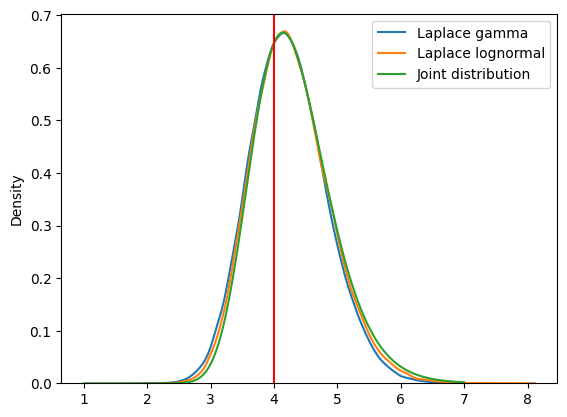

In [78]:
q_gamma = torch.distributions.Gamma(q_shape_map, q_rate_map)
xd = q_gamma.sample((100000,)).numpy().flatten()
sns.kdeplot(xd, label='Laplace gamma')

q_lnorm = torch.distributions.LogNormal(q_mu_map, q_sigma_map)
xd = q_lnorm.sample((100000,)).numpy().flatten()
sns.kdeplot(xd, label='Laplace lognormal')

plt.plot(x, y, label='Joint distribution')
plt.axvline(true_theta, c='r')
plt.legend(loc="upper right")
plt.show()

The plot above shows that the distribution of the population size parameter is somehow asymmetric, the right tail being a bit fatter than the right one. Clearly a truncated normal distribution would struggle to fit this distribution.

Similarly the parameters of the gamma distribution can be estimated:

In [79]:
q_rate_map = mape * -d2logP
q_shape_map = q_rate_map*mape + 1.0
print('shape = {:.3f} rate = {:.3f}'.format(q_shape_map, q_rate_map))

shape = 50.000 rate = 11.833


## Fast approximation of population size distribution
## Variational inference  <a name="vb"></a>
Next we are going to estimate the population parameter of a constant size coalescent model using the intervals we just simulated. The parameter is estimated using Variational inference with the PyTorch framework. The support of the population size parameter is $\mathbb{R}^+$ so a log transformation is used to map it on the real line. It is optimized using the Adam algorithm.

It is common to use the Jeffreys prior on the population size parameter:
$$f(\theta) \propto \frac{1}{\theta}$$

The posterior distribution of the population size is:

\begin{align}
p(\theta \mid t_1, \dots, t_{N-1}, T) &\propto p(t_1, \dots, t_{N-1} \mid \theta, T) f(\boldsymbol{\theta})\\
&= \frac{1}{\theta} \prod_{k=2}^{N} \frac{1}{\theta} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta} \right]
\end{align}

Variational Bayes methods provide an analytical approximation to the posterior probability and a lower bound for the marginal likelihood.
The main idea is to choose a family of distributions $q$ parametrised with parameters $\boldsymbol{\phi}$ and to minimize the Kullback Leibler (KL) divergence from variational distribution $q$ to the posterior distribution $p$ of interest

$$ \boldsymbol{\phi}^{*} = \text{argmin}_{\boldsymbol{\phi} \in \boldsymbol{\Phi}}  \mathrm{KL}(q(\boldsymbol{\theta}; \boldsymbol{\phi}) \parallel p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})). $$

It is difficult to minimise the KL divergence directly but much easier to minimize a function that is equal to it up to a constant.
Expanding the KL divergence we get

$$\begin{aligned}
\mathrm{KL}(q(\boldsymbol{\theta}; \boldsymbol{\phi}) \parallel p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})) &= \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})] - \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})] \\
  & = \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})] - \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta}, t_1, \dots, t_{N-1})] + \log p(t_1, \dots, t_{N-1})\\
    & = -\textrm{ELBO}(\boldsymbol{\phi}) + \log p(t_1, \dots, t_{N-1}),
\end{aligned}$$
where $\textrm{ELBO}(\boldsymbol{\phi}) = \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta}, t_1, \dots, t_{N-1})] - \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})]$.
This equation suggests that the $\textrm{ELBO}(\boldsymbol{\phi})$ is the lower bound of the evidence: $\log p(t_1, \dots, t_{N-1}) \geq \textrm{ELBO}(\boldsymbol{\phi})$.


Instead of minimizing KL divergence, we maximize  the evidence lower bound:
$$ \textrm{ELBO}(\boldsymbol{\phi}) = \mathop{\mathbb{E}}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[\log p(t_1, \dots, t_{N-1}, \boldsymbol{\theta}) - \log q(\boldsymbol{\theta}; \boldsymbol{\phi})].$$


In [80]:
lr_lambda = lambda epoch: 1.0/math.sqrt(epoch+1)
sampling_times = torch.zeros(taxon_count)
heights = torch.cat((sampling_times, torch.tensor(heights_list)))

def calculate_elbo_constant(q_theta, size):
    z = q_theta.rsample(size)
    coalescent = ConstantCoalescent(z)
    logQ = q_theta.log_prob(z)
    logPrior = -z.log() # Jeffreys: 1/theta
    logP = coalescent.log_prob(heights)
    return  logP + logPrior - logQ

## Variational distribution: lognormal

In [81]:
theta_mu = torch.randn(1, requires_grad=True)
theta_sigma = torch.randn(1, requires_grad=True)

optimizer = torch.optim.Adam( (theta_mu, theta_sigma), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []
mu_grads = []
sigma_grads = []
mus = []
sigmas = []

def elbo_lognormal(size=(1,)):
    q_theta = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
    return calculate_elbo_constant(q_theta, size).mean()

iters = tqdm(range(50000), mininterval=1)
for epoch in iters:
# for epoch in range(50000):
    mus.append(theta_mu.item())
    sigmas.append(theta_sigma.exp().item())
    
    loss = -elbo_lognormal()
    
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads.append(theta_mu.grad.item())
    sigma_grads.append(theta_sigma.grad.item()**2)
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_lognormal((100,)).item()))

  0%|          | 0/50000 [00:00<?, ?it/s]

Final ELBO: -120.64024645049106


The next two plots show the full trajectory of the ELBO on the left and the trajectory for the last 40000 iterations on the right. The ELBO has stabilized around -121.

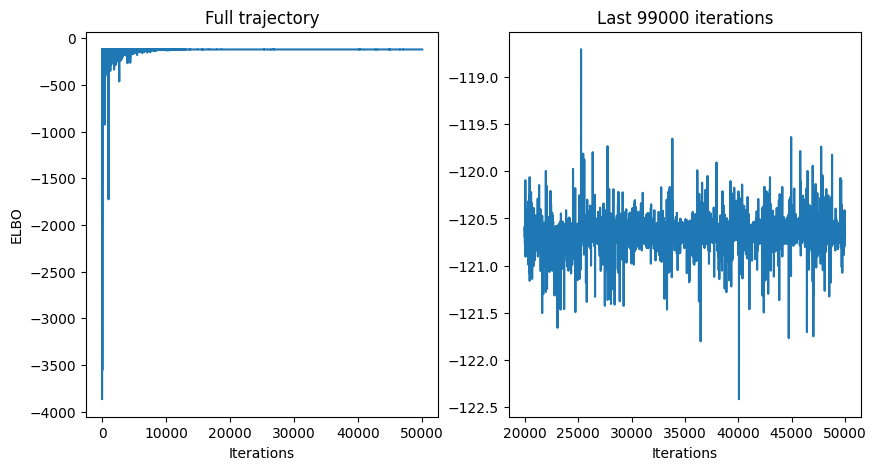

In [82]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(elbo_hist)
axes[0].set_title('Full trajectory')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('ELBO')

axes[1].plot(list(range(20000, len(elbo_hist))), elbo_hist[20000:])
axes[1].set_title('Last 99000 iterations')
axes[1].set_xlabel('Iterations')
plt.show()

This plot shows the estimated lognormal distribution (variational distribution). The red line represents the true value of the population size parameter.

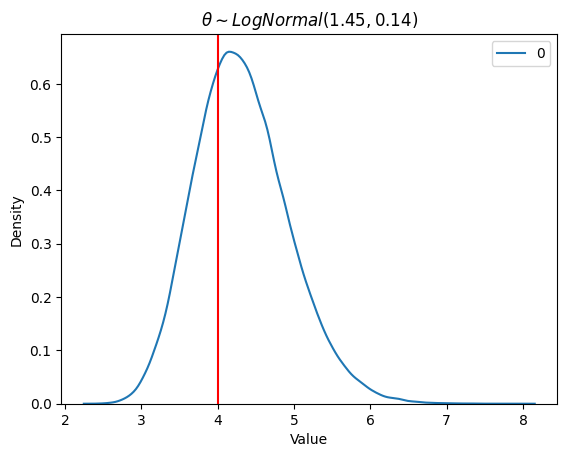

In [83]:
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
x = m.sample((100000,)).numpy()
sns.kdeplot(x)
plt.axvline(true_theta, c='r')
plt.xlabel('Value')
plt.title(r'$\theta \sim LogNormal({:.2f},{:.2f})$'.format(theta_mu.item(), theta_sigma.exp().item()))
plt.show()

In [84]:
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
x = np.arange(1,7, 0.001)
xt = torch.tensor(x)
mus2 = mus[:20000:50]
sigmas2 = sigmas[:20000:50]
elbos = elbo_hist[:20000:50]
def animate(i):
    ax1.clear()
    q_theta = torch.distributions.LogNormal(torch.tensor([mus2[i]]), torch.tensor([sigmas2[i]]))
    yy = q_theta.log_prob(xt).exp().numpy().flatten()

    ax1.plot(x, yy, 'k-')
    ax1.plot(x, y, label='Log joint distribution', c='r')
    ax1.text(x[6], np.max(y), 'ELBO = {:.2f}'.format(elbos[i]))

anim = animation.FuncAnimation(fig, animate, interval=100, frames=len(mus2), repeat=False)
plt.close()

## Variational distribution: inverse gamma

In [85]:
theta_alpha_i = torch.tensor([4.], requires_grad=True)
theta_beta_i = torch.tensor([4.], requires_grad=True)

optimizer = torch.optim.Adam( (theta_alpha_i, theta_beta_i), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist3 = []

def elbo_inverse_gamma(size=(1,)):
    q_theta = InverseGamma(theta_alpha_i.exp(), theta_beta_i.exp())
    return calculate_elbo_constant(q_theta, size).mean()

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    loss = -elbo_inverse_gamma()
    
    elbo_hist3.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist3[-1]), refresh=False)

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_inverse_gamma((100,)).item()))

  0%|          | 0/100000 [00:00<?, ?it/s]

Final ELBO: -120.65608810069254


## Variational distribution: gamma

In [86]:
theta_alpha = torch.tensor([np.log(q_shape_map)], requires_grad=True)
theta_beta = torch.tensor([np.log(q_rate_map)], requires_grad=True)

optimizer = torch.optim.Adam( (theta_alpha, theta_beta), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist2 = []
mu_grads2 = []
sigma_grads2 = []

    
def elbo_gamma(size=(1,)):
    q_theta = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
    return calculate_elbo_constant(q_theta, size).mean()

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    loss = -elbo_gamma()
    
    elbo_hist2.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads2.append(theta_alpha.grad.item())
    sigma_grads2.append(theta_beta.grad.item()**2)
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist2[-1]), refresh=False)
    
with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_gamma((100,)).item()))

  0%|          | 0/100000 [00:00<?, ?it/s]

Final ELBO: -120.66949863742879


In [87]:
def elbo_gamma_laplace(size=(1,)):
    q_theta = torch.distributions.Gamma(q_shape_map, q_rate_map)
    z = q_theta.rsample(size)
    z = z.unsqueeze(-1)
    coalescent = ConstantCoalescent(z)
    logQ = q_theta.log_prob(z)
    logPrior = -z # Jeffreys: 1/theta
    logP = coalescent.log_prob(heights)
    return (logP + logPrior - logQ).mean()

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_gamma_laplace((100,)).item()))

Final ELBO: -123.43476406856637


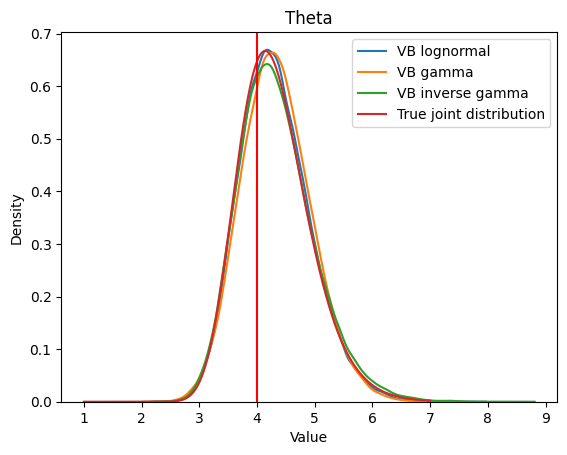

In [88]:
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
mg = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
mig = InverseGamma(theta_alpha_i.exp(), theta_beta_i.exp())
x = m.sample((100000,))
x = x.numpy().flatten()
sns.kdeplot(x, label='VB lognormal')

xg = mg.sample((100000,))
xg = xg.numpy().flatten()
sns.kdeplot(xg, label='VB gamma')

xig = mig.sample((100000,))
xig = xig.numpy().flatten()
sns.kdeplot(xig, label='VB inverse gamma')

plt.plot(np.arange(1,7, 0.001), y, label='True joint distribution')
plt.axvline(true_theta, c='r')
plt.xlabel('Value')
plt.title('Theta')

plt.legend(loc="upper right")
plt.show()

Visually the lognormal outperforms the gamma and inverse gamma distribution. The ELBO estimates can have high variance and might be of little use to discriminate between closely related models (in the KL sense).
What if we use these approximations to calculate the marginal likelihood using importance sampling with the variational distribution $q$ as the importance distribution. This yields the $\hat{p}_{\text{VBIS}}(t_1,\dots, t_{N-1})$ estimator:

$$
\hat{p}_{\text{VBIS}}(t_1,\dots, t_{N-1}) = \frac{1}{K} \sum_{i=1}^K \frac{p(t_1,\dots, t_{N-1} \mid \tilde{\boldsymbol{\theta}_i}) p(\tilde{\boldsymbol{\theta}_i})}{q_{\text{ELBO}}(\tilde{\boldsymbol{\theta}_i})}, \tilde{\boldsymbol{\theta}}_i \sim q_{\text{ELBO}}(\boldsymbol{\theta}).
$$

In [89]:
samples = 100000
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
z = m.sample((samples,))
lq = m.log_prob(z)
constant = ConstantCoalescent(z)
lp = constant.log_prob(heights) - z.log()
print('Lognormal log marginal = {}'.format(torch.logsumexp(lp-lq, 0).item() - torch.tensor(samples).log()))

mg = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
z = mg.sample((samples,))
lq = mg.log_prob(z)
constant = ConstantCoalescent(z)
lp = constant.log_prob(heights) - z.log()
print('Gamma log marginal = {}'.format(torch.logsumexp(lp-lq, 0).item() - torch.tensor(samples).log()))

ll = lambda theta : np.exp(constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), theta) - np.log(theta) - ml)
lml, _ = np.log(integrate.quad(ll, 0, np.inf)) + ml
print('Quad log marginal      = {}'.format(lml))

Lognormal log marginal = -120.63937377929688
Gamma log marginal = -120.64015197753906
Quad log marginal      = -120.63940302961623


## Hepatitis C Outbreak in Egypt <a name="hcv"></a>

In [90]:
hcv_heights_list = (
        0.337539776803851, 1.47598666181676, 2.59836642809404, 10.5419856428014, 10.6808211320844, 15.3216302200854,
        32.9562682261327, 35.2648938177678, 36.7219608418798, 36.737540711423, 37.2708231729614, 37.7849554073031,
        39.4937183636496, 39.5351866235332, 40.2051118111069, 40.272699980689, 42.8275583168662, 45.0143000059112,
        46.5121661847954, 47.1448952249262, 47.504526489029, 47.9616614709545, 48.3715795210146, 48.483790544288,
        48.7943022569899, 50.4087925250658, 51.2112016897755, 51.2609695712131, 51.878675348271, 54.1904624765934,
        55.4352237750807, 55.5550828199461, 55.9082058859295, 61.1133486466791, 61.2488301435699, 61.6467848736123,
        61.8450615919513, 63.090453292149, 66.1723097114625, 66.981821939552, 68.9496036301138, 69.0585863605563,
        69.3140166961911, 70.088816523003, 70.582823656852, 72.0200679613929, 72.0372853199532, 72.1961653985567,
        72.4862745825324, 74.6256268205132, 74.6985113851702, 78.4868903769909, 79.3977257023136, 83.4281836229148,
        85.2297867264788, 87.6518990828725, 89.1434858206649, 94.7629800718393, 224.733954965067, 232.942753855407,
        251.57871299307, 277.961578642117)
taxon_count = len(hcv_heights_list) + 1
sampling_times = torch.tensor([0.0])
heights = torch.cat((torch.zeros(taxon_count), torch.tensor(hcv_heights_list)), -1)

intervals = np.array([0.0] + list(hcv_heights_list))
intervals = intervals[1:] - intervals[:-1]
lineages = list(range(taxon_count, 1, -1))
times = [1994. - x for x in hcv_heights_list]
mles = binom(lineages, 2) * intervals
mle = np.mean(mles)
print('MLE: {:.2f} log(MLE): {:.2f}'.format(mle, np.log(mle)))

MLE: 1378.86 log(MLE): 7.23


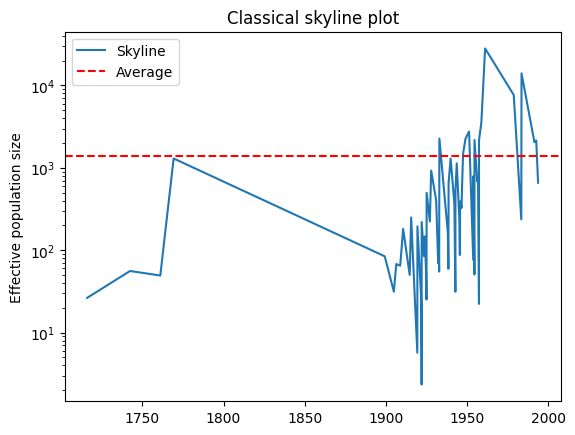

In [91]:
plt.plot(times, binom(lineages, 2) * intervals, '-', label='Skyline')
plt.title('Classical skyline plot')
plt.ylabel('Effective population size')
plt.axhline(mle, linestyle='--', c='r', label='Average')
plt.yscale('log')
plt.legend(loc="upper left")
plt.show()

## Varational inference <a name="hcv-vb"></a>

## Transformation of population size parameters

\begin{align}
\tilde\theta_k &= \log\theta_k, k = 2, \dots, N \\
\Delta_i &= \tilde\theta_{i+1} - \tilde\theta_{i}, i = 2, \dots, N-1\\
\end{align}

## Meanfield on $\boldsymbol{\theta}$, centered parameterization, GMRF, and $Gamma(\tau)$

The gamma distribution is parameterized with the shape and rate parameters. The normal distribution is parameterized with the precision parameter $\tau=\frac{1}{\sigma^2}$.

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, 1/\tau)\\
\tau \sim \mathit{Gamma}(0.001,0.001)\\
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

\begin{align}
p(\theta_2, \dots, \theta_N, \tau \mid T) &= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) |\det J|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{d \log \theta_i}{d \theta_i}\right|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{1}{\theta_i}\right|
\end{align}

### Variational model: meanfield gamma

Meanfield gamma distribution on $\boldsymbol{\theta}$:
$$ q(\boldsymbol\theta, \tau; \mu, \sigma, \boldsymbol\alpha, \boldsymbol\beta) = LogNormal(\tau; \mu, \sigma) \prod_{i=1}^N Gamma(\theta_i; \alpha_i, \beta_i)$$

In [92]:
# parameters of the gamma distributions for the population size parameters
thetas_shape = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
thetas_rate = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
# parameters of the normal distributions for the population size differences
tau_mu = torch.tensor([0.1], requires_grad=True)
tau_sigma = torch.tensor([0.1], requires_grad=True)

optimizer = torch.optim.Adam((thetas_shape, thetas_rate, tau_mu, tau_sigma),
                              lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# gamma prior on precision parameter tau
prior_tau = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.Gamma(thetas_shape.exp(), thetas_rate.exp())
    q_tau = torch.distributions.LogNormal(tau_mu, tau_sigma.exp())
    thetas = q_theta.rsample()
    tau = q_tau.rsample()
    
    logQ = q_theta.log_prob(thetas).sum() + q_tau.log_prob(tau)
    
    # GMRF prior
    scale = torch.tensor([1.0])/tau.sqrt()
    prior_gmrf = torch.distributions.Normal(0, scale)
    z = thetas.log()
    logPrior = prior_gmrf.log_prob(z[:-1] - z[1:]).sum() + prior_tau.log_prob(tau) + prior_theta.log_prob(z[0])
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(heights) - z.sum()
    loss = -(logP + logPrior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

## Meanfield on $\boldsymbol{\Delta}$, non-centered parameterization, GMRF, and $Gamma(\tau)$

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, 1/\tau)\\
\tau \sim \mathit{Gamma}(0.001,0.001)\\
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

\begin{align}
p(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau \mid T) &= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) |det J| \\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i}\tilde\theta_{i-1} + \Delta_i \right|\\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T)\\
%&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i} \tilde\theta_1 + \sum_{j=2}^{i}\Delta_j \right|\\
\end{align}

### Variational model: meanfield normal

Meanfield normal distribution on $\boldsymbol{\Delta}$ and $\tilde\theta_1$:
$$ q(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau; \mu, \sigma) = LogNormal(\tau; \mu_\tau, \sigma_\tau) Normal(\tilde\theta_N; \mu_N, \sigma_N) \prod_{i=2}^{N-1} Normal(\Delta_i; \mu_i, \sigma_i)$$

In [93]:
theta_mu = torch.tensor([8.0], requires_grad=True)
theta_sigma = torch.tensor([-2.0], requires_grad=True)
deltas_mu = torch.tensor([-0.05]*(taxon_count-2), requires_grad=True)
deltas_sigma = torch.tensor([-2.2]*(taxon_count-2), requires_grad=True)
tau_mu = torch.tensor([4.2], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

optimizer = torch.optim.Adam((theta_mu, theta_sigma, 
                              deltas_mu, deltas_sigma, 
                              tau_mu, tau_sigma),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# gamma prior on precision parameter tau
prior_tau = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
    q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
    q_tau = torch.distributions.LogNormal(tau_mu, tau_sigma.exp())
    log_theta = q_theta.rsample()
    deltas = q_deltas.rsample()
    tau = q_tau.rsample()
    
    logQ = q_theta.log_prob(log_theta) + q_deltas.log_prob(deltas).sum() + q_tau.log_prob(tau)
    
    thetas = torch.cat((log_theta, deltas)).cumsum(0).exp()
    
    # GMRF prior
    scale = torch.tensor([1.0])/tau.sqrt()
    prior_gmrf = torch.distributions.Normal(0, scale)
    
    log_prior = prior_theta.log_prob(log_theta) + prior_gmrf.log_prob(deltas).sum() + prior_tau.log_prob(
            tau) + prior_theta.log_prob(log_theta[0])
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(heights)

    loss = -(logP + log_prior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

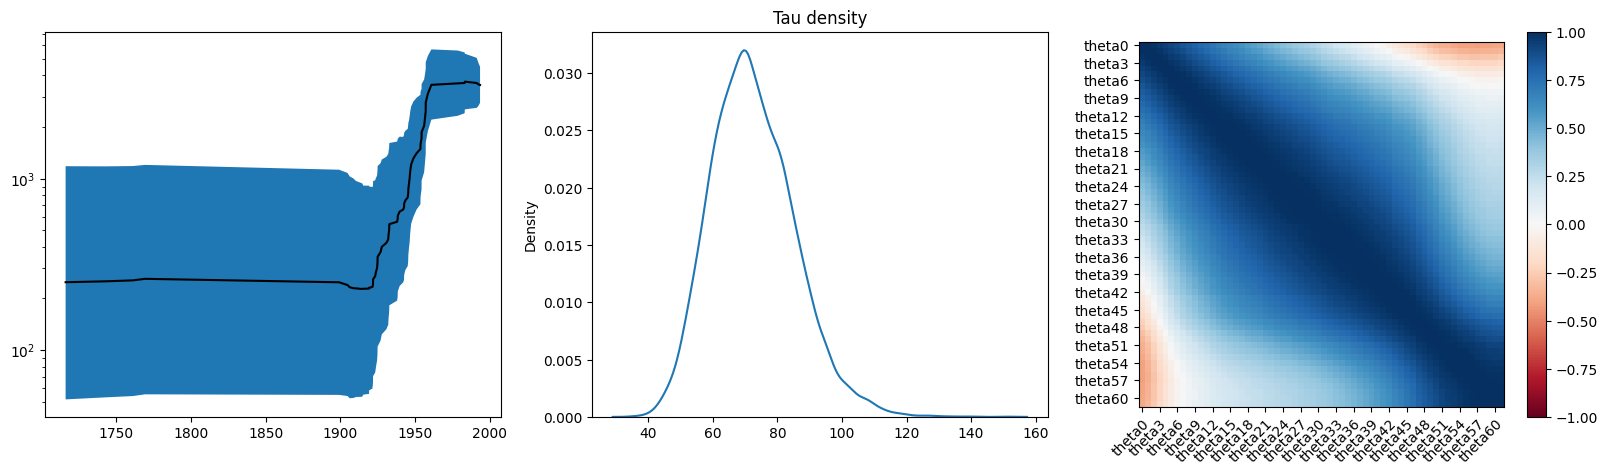

In [94]:
f, axes = plt.subplots(1, 3, figsize=(20,5))

q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
theta = np.squeeze(q_theta.sample((10000,)).numpy())
theta = np.expand_dims(theta, axis=1)
deltas = np.squeeze(q_deltas.sample((10000,)).numpy())

thetas = np.exp(np.concatenate((theta, deltas), axis=1).cumsum(1))
mm =np.mean(thetas, 0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

taus = torch.distributions.LogNormal(tau_mu, tau_sigma.exp()).sample((10000,))
taus = taus.numpy().flatten()
sns.kdeplot(taus, ax=axes[1])
axes[1].set_title('Tau density')

axes[2].set_xticks(np.arange(0, thetas.shape[1], 3))
axes[2].set_yticks(np.arange(0, thetas.shape[1], 3))
im = axes[2].imshow(np.corrcoef(np.cov(np.transpose(thetas))), vmin=-1, vmax=1, cmap='RdBu')
axes[2].set_xticklabels(['theta{}'.format(i) for i in np.arange(0, thetas.shape[1], 3)])
axes[2].set_yticklabels(['theta{}'.format(i) for i in np.arange(0, thetas.shape[1], 3)])

plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im, ax=axes[2])

plt.show()

# HMC <a name="hcv-hmc"></a>

In [95]:
from torchtree.evolution.coalescent import PiecewiseConstantCoalescentModel, ConstantCoalescentModel, PiecewiseConstantCoalescentGridModel, FakeTreeModel
from torchtree.core.parameter import Parameter, TransformedParameter
from torchtree.inference.mcmc.mcmc import MCMC
from torchtree.inference.hmc.operator import HMCOperator
from torchtree.inference.mcmc.operator import SlidingWindowOperator
from torchtree.inference.hmc.integrator import LeapfrogIntegrator
from torchtree.distributions.joint_distribution import JointDistributionModel
from torchtree.core.logger import ContainerLogger, LoggerInterface
from torchtree.distributions.distributions import Distribution
from torchtree.distributions.gmrf import GMRF
from collections import OrderedDict
from torchtree.inference.mcmc.block_updating import GMRFPiecewiseCoalescentBlockUpdatingOperator

In [96]:
def create_parameters_exp(id_, value):
    log_param = Parameter(f"log_{id_}", value)
    param = TransformedParameter(id_, log_param, torch.distributions.ExpTransform())
    return param, log_param

def create_joint_skyride():
    pop_sizes, log_pop_sizes = create_parameters_exp("pop_sizes", torch.full((taxon_count-1,), 5.0))
    tree_model = FakeTreeModel(Parameter("heights", heights))
    skyride = PiecewiseConstantCoalescentModel("skyride", pop_sizes, tree_model)
    precision, log_precision = create_parameters_exp("precision",  torch.tensor([1.0]))
    gmrf = GMRF("gmrf", log_pop_sizes, precision)

    args = OrderedDict()
    args["concentration"] = Parameter(None, torch.tensor(0.001))
    args["rate"] = Parameter(None, torch.tensor(0.001))
    precision_prior = Distribution("precision_prior", torch.distributions.Gamma, precision, args)
    joint = JointDistributionModel("joint", [skyride, gmrf, precision_prior, precision])
    return joint, pop_sizes, precision, log_pop_sizes, log_precision

def create_joint_skygrid(theta_count, cutoff):
    pop_sizes, log_pop_sizes = create_parameters_exp("pop_sizes", torch.full((theta_count,), 5.0))
    tree_model = FakeTreeModel(Parameter("heights", heights))
    grid = Parameter("grid", torch.linspace(0, cutoff, pop_sizes.shape[-1])[1:])
    skygrid = PiecewiseConstantCoalescentGridModel("skygrid", pop_sizes, grid, tree_model)
    precision, log_precision = create_parameters_exp("precision",  torch.tensor([1.0]))
    gmrf = GMRF("gmrf", log_pop_sizes, precision)

    args = OrderedDict()
    args["concentration"] = Parameter(None, torch.tensor(0.001))
    args["rate"] = Parameter(None, torch.tensor(0.001))
    precision_prior = Distribution("precision_prior", torch.distributions.Gamma, precision, args)
    joint = JointDistributionModel("joint", [skygrid, gmrf, precision_prior, precision])
    return joint, pop_sizes, precision, log_pop_sizes, log_precision



In [97]:
class TqdmLogger(object):
    def __init__(self, iterations: int, obj):
        self.t = tqdm(total=iterations, bar_format="{l_bar} {postfix[0]}: {postfix[1][value]:.3f}",
          postfix=["Log prob", {"value": 0}])
        self.obj = obj
    
    def log(self, *args, **kwargs) -> None:
        self.t.postfix[1]["value"] = self.obj().item()
        self.t.update()
    
    def initialize(self) -> None:
        pass

    def close(self) -> None:
        pass


In [98]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skyride()

integrator = LeapfrogIntegrator("leapfrog", 5, 0.1)
mass_matrix = Parameter("mass_matrix", torch.ones(taxon_count))
operator = HMCOperator("operator", joint, [log_pop_sizes, log_precision], 1, 0.8, integrator, mass_matrix, [], disable_adaptation=False)
samples_hmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_hmc, 100)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator 0.7894 10000 0.13403171329694233


In [99]:
theta_count = 75
cutoff = hcv_heights_list[-1]
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skygrid(theta_count, cutoff)

integrator = LeapfrogIntegrator("leapfrog", 5, 0.1)
mass_matrix = Parameter("mass_matrix", torch.ones(theta_count + 1))
operator = HMCOperator("operator", joint, [log_pop_sizes, log_precision], 1, 0.8, integrator, mass_matrix, [], disable_adaptation=False)
samples_skygrid_hmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skygrid_hmc, 100)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator 0.8749 10000 0.1302959419195929


In [100]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skyride()

samples_skyride_mcmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skyride_mcmc, 100)
operator_pop = SlidingWindowOperator("operator1", [log_pop_sizes], 1, 0.24, 0.9)
operator_precision = SlidingWindowOperator("operator2", [log_precision], 1, 0.24, 0.9)
iterations = 100000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator_pop, operator_precision], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator1 0.29382327139325304 50156 3.2997987591183
operator2 0.22662707647861327 49844 2.5302708904502396


In [101]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skygrid(theta_count, cutoff)

samples_skygrid_mcmc = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skygrid_mcmc, 100)
operator_pop = SlidingWindowOperator("operator1", [log_pop_sizes], 1, 0.24, 0.9)
operator_precision = SlidingWindowOperator("operator2", [log_precision], 1, 0.24, 0.9)
iterations = 100000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator_pop, operator_precision], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator1 0.3131691113201129 49973 0.6272530802182619
operator2 0.22385911607731826 50027 2.3474058468094774


In [102]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skyride()
skyride = joint._distributions.skyride
gmrf = joint._distributions.gmrf

samples_skyride_mcmc_bu = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skyride_mcmc_bu, 100)
operator = GMRFPiecewiseCoalescentBlockUpdatingOperator("operator2", [log_precision, log_pop_sizes], skyride, gmrf, 1, 0.24, 2.0)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator2 0.3065 10000 9.852103057015125


In [103]:
joint, pop_sizes, precision, log_pop_sizes, log_precision = create_joint_skygrid(theta_count, cutoff)
skygrid = joint._distributions.skygrid
gmrf = joint._distributions.gmrf

samples_skygrid_mcmc_bu = []
logger=ContainerLogger([joint, pop_sizes, precision], samples_skygrid_mcmc_bu, 100)
operator = GMRFPiecewiseCoalescentBlockUpdatingOperator("operator2", [log_precision, log_pop_sizes], skygrid, gmrf, 1, 0.24, 2.0)
iterations = 10000
logger_tqdm = TqdmLogger(iterations, joint)
mcmc = MCMC(joint, [operator], iterations, loggers=[logger_tqdm, logger], every=0)
mcmc.run()

  0%| Log prob: 0.000

operator2 0.2604 10000 4.706820033734848


In [104]:
grid = 1994 - torch.linspace(0, cutoff, theta_count).numpy()

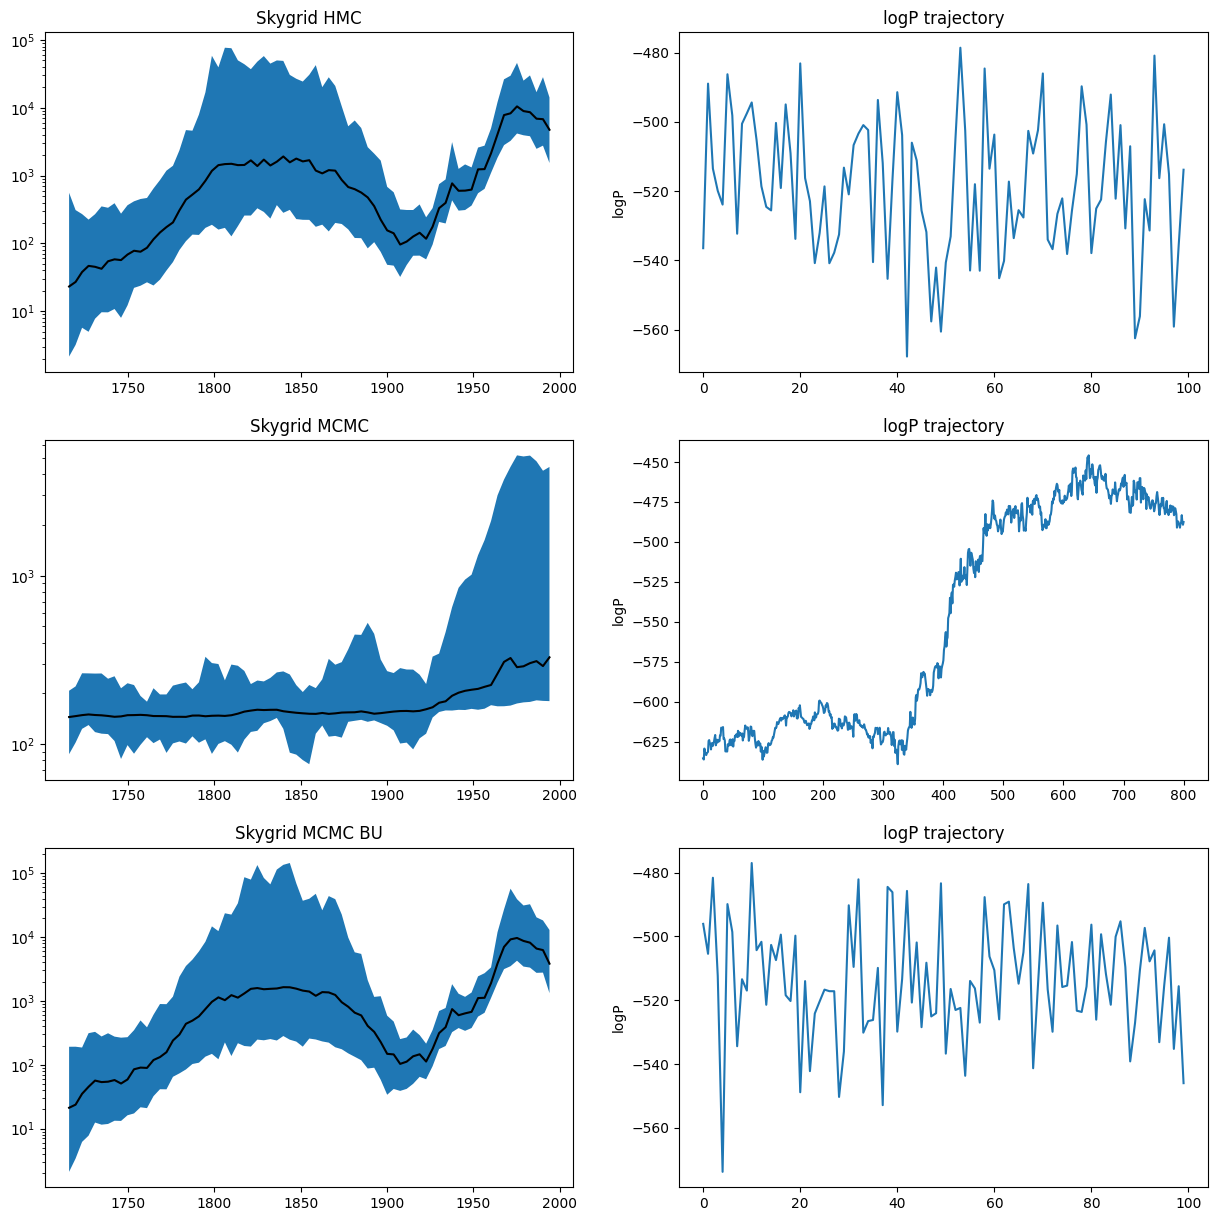

In [105]:
f, axes = plt.subplots(3, 2, figsize=(15,15))

thetas_skygrid_hmc=np.array(samples_skygrid_hmc)[1:,1:-1]
quants = np.quantile(thetas_skygrid_hmc, (0.025, 0.5, 0.975), 0)
axes[0,0].plot(grid, quants[1], 'k-')
axes[0,0].fill_between(grid, quants[0], quants[2])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Skygrid HMC')

thetas_skygrid_mcmc=np.array(samples_skygrid_mcmc)[200:,1:-1]
quants = np.quantile(thetas_skygrid_mcmc, (0.025, 0.5, 0.975), 0)
axes[1,0].plot(grid, quants[1], 'k-')
axes[1,0].fill_between(grid, quants[0], quants[2])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Skygrid MCMC')

thetas_skygrid_mcmc_bu=np.array(samples_skygrid_mcmc_bu)[1:,1:-1]
quants = np.quantile(thetas_skygrid_mcmc_bu, (0.025, 0.5, 0.975), 0)
axes[2,0].plot(grid, quants[1], 'k-')
axes[2,0].fill_between(grid, quants[0], quants[2])
axes[2,0].set_yscale('log')
axes[2,0].set_title('Skygrid MCMC BU')

axes[0,1].plot(np.array(samples_skygrid_hmc)[1:,:1])
axes[0,1].set_title('logP trajectory')
axes[0,1].set_ylabel('logP')

axes[1,1].plot(np.array(samples_skygrid_mcmc)[200:,:1])
axes[1,1].set_title('logP trajectory')
axes[1,1].set_ylabel('logP')

axes[2,1].plot(np.array(samples_skygrid_mcmc_bu)[1:,:1])
axes[2,1].set_title('logP trajectory')
axes[2,1].set_ylabel('logP')

plt.show()

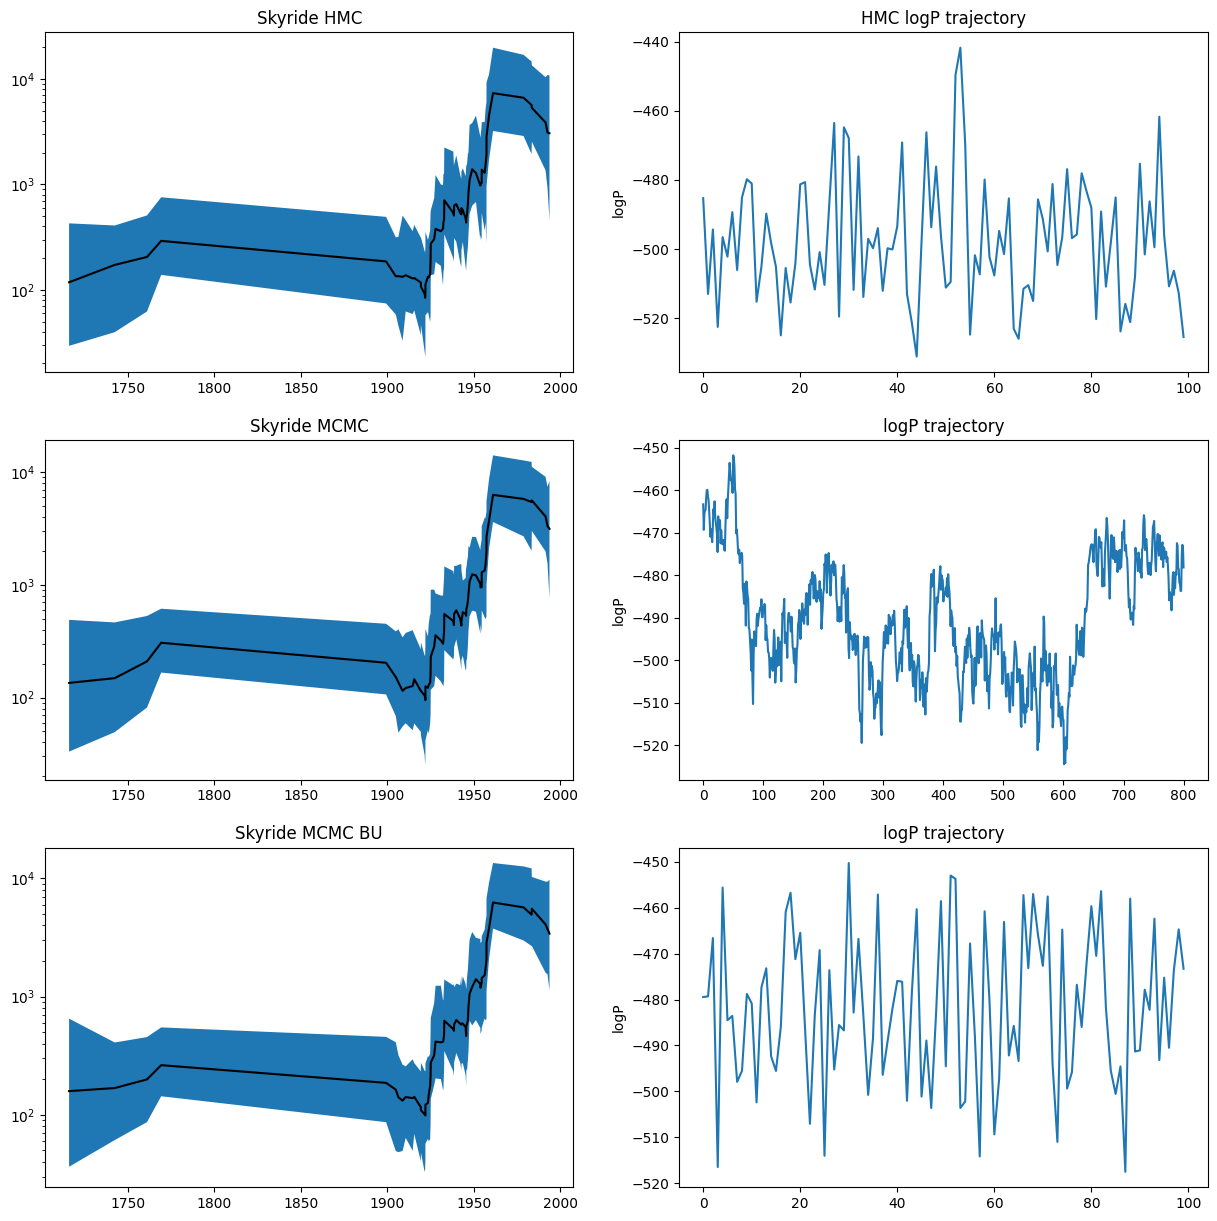

In [106]:
f, axes = plt.subplots(3, 2, figsize=(15,15))

thetas_hmc=np.array(samples_hmc)[1:,1:-1]
quants = np.quantile(thetas_hmc, (0.025, 0.5, 0.975), 0)
axes[0,0].plot(times, quants[1], 'k-')
axes[0,0].fill_between(times, quants[0], quants[2])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Skyride HMC')

thetas_skyride_mcmc=np.array(samples_skyride_mcmc)[200:,1:-1]
quants = np.quantile(thetas_skyride_mcmc, (0.025, 0.5, 0.975), 0)
axes[1,0].plot(times, quants[1], 'k-')
axes[1,0].fill_between(times, quants[0], quants[2])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Skyride MCMC')

thetas_skyride_mcmc_bu=np.array(samples_skyride_mcmc_bu)[1:,1:-1]
quants = np.quantile(thetas_skyride_mcmc_bu, (0.025, 0.5, 0.975), 0)
axes[2,0].plot(times, quants[1], 'k-')
axes[2,0].fill_between(times, quants[0], quants[2])
axes[2,0].set_yscale('log')
axes[2,0].set_title('Skyride MCMC BU')

axes[0,1].plot(np.array(samples_hmc)[1:,:1])
axes[0,1].set_title('HMC logP trajectory')
axes[0,1].set_ylabel('logP')

axes[1,1].plot(np.array(samples_skyride_mcmc)[200:,:1])
axes[1,1].set_title('logP trajectory')
axes[1,1].set_ylabel('logP')

axes[2,1].plot(np.array(samples_skyride_mcmc_bu)[1:,:1])
axes[2,1].set_title('logP trajectory')
axes[2,1].set_ylabel('logP')

plt.show()

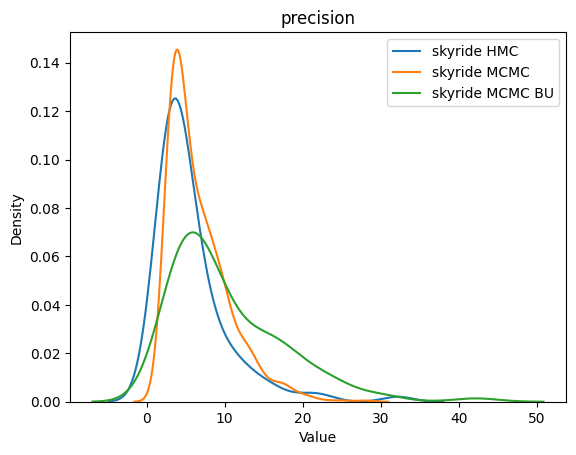

In [107]:
sns.kdeplot(np.array(samples_hmc)[1:,-1], label='skyride HMC')
sns.kdeplot(np.array(samples_skyride_mcmc)[200:,-1], label='skyride MCMC')
sns.kdeplot(np.array(samples_skyride_mcmc_bu)[1:,-1], label='skyride MCMC BU')

plt.xlabel('Value')
plt.title('precision')
plt.legend(loc="upper right")
plt.show()

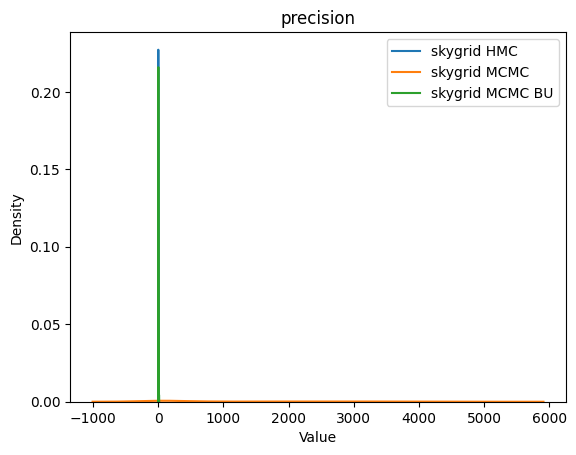

In [108]:
sns.kdeplot(np.array(samples_skygrid_hmc)[1:,-1], label='skygrid HMC')
sns.kdeplot(np.array(samples_skygrid_mcmc)[200:,-1], label='skygrid MCMC')
sns.kdeplot(np.array(samples_skygrid_mcmc_bu)[1:,-1], label='skygrid MCMC BU')

plt.xlabel('Value')
plt.title('precision')
plt.legend(loc="upper right")
plt.show()